In [1]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2024)

tc = create_taiga_client_v3()


In [54]:

class OrderParamClassifier:
    """to classify samples based on their gene expression profiles and their corresponding cell or disease type annotations. """
    def __init__(self, expr, markers, num_samples): 
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples= num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)

def get_gene_map(tc):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type','entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()),'depmap'] = np.nan
    #ensembl = generateGeneNames(attributes=['ensembl_transcript_id'])
    #hgnc['ensembl_transcript_id'] = pd.merge(hgnc.ensembl_gene_id,ensembl.set_index('ensembl_gene_id').ensembl_transcript_id)
    return hgnc


def get_tcga_classifier(num_samples):
    """
    """
    # Get and fill missing values with 0 in TCGA expression data
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    
    # Get DepMap expression data
    depmap = tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
    
    # Retrieve gene map
    gene_map = get_gene_map(tc)
    
    # Rename DepMap expression data columns based on gene map ensembl_gene_id column 
    expr_depmap = depmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())
    
    # Identify common genes between TCGA and DepMap expression data
    commongenes = tcga_expr.columns.intersection(expr_depmap.columns)
    
    # Subset TCGA expression data to keep only the common genes
    tcga_expr = tcga_expr[commongenes]
    
    # Read TCGA metadata 
    tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv') # HAS THE CNS UPDATE AND ADENOIOD 
    # Set sampleID as index and get the new_subtype column for annotations
    tcga_ann = tcga_meta.set_index('sampleID').new_subtype
    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier


def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [3]:
#tcga_meta = pd.read_csv('/Users/nabdirah/Project1/newtcga_meta_final.csv')
#tcga_meta=pd.read_csv('/Users/nabdirah/Project1/realtcga.csv')

In [55]:
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/3TCGA.csv')

In [59]:
# read data 
debmap=tc.get('internal-24q2-3719.82/OmicsExpressionProteinCodingGenesTPMLogp1BatchCorrected')
metadata = tc.get('internal-24q2-3719.82/Model')

In [6]:
gene_map=get_gene_map(tc)
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna())	# get the ensembl_gene_id column from gene_map 
#and replace the columns depmap to the values in this column 
expr_depmap=debmap.rename(columns=gene_map.set_index('depmap').ensembl_gene_id.dropna()) 

In [ ]:
# use 25 samples 
num_samples = 25
# Get the TCGA classifier with the specified number of samples
classifier = get_tcga_classifier(num_samples)
# Train the classifier
classifier.train()

In [62]:
# Identify the common genes between the columns of expr_depmap and the columns of classifier.exp
# Score the expression data from expr_depmap for the common genes using the classifier
# Drop columns with any missing values (NaN) before scoring
# Extract the projections
common_genes = expr_depmap.columns.intersection(classifier.expr.columns) 
score_data=classifier.score(expr_depmap[common_genes].dropna(axis=1))
score_data=score_data[0] # a Dataframe with columns as the samples and the rows as the subtypes 

In [64]:
# get the top3 predicted subtypes for each sample 
Top_score=score_data.apply(lambda x: x.sort_values(ascending=False).iloc[:3].index,axis = 0)
Top_score=Top_score.T
Top_score.reset_index(inplace=True)
Top_score.rename(columns={'index': 'sample'}, inplace=True)


In [66]:
#oncotree data 
oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")
oncotree=oncotree.reset_index()
# Group by 'name' and count unique 'oncotree_code' values
oncotree_code_counts = oncotree.groupby('name')['code'].nunique()

# Filter names with more than one unique OncoTree code
names_with_multiple_codes = oncotree_code_counts[oncotree_code_counts > 1]
def update_name(row):
    if row['name'] in names_with_multiple_codes:
        return f"{row['name']} ({row['tissue']})"
    return row['name']

oncotree['name'] = oncotree.apply(update_name, axis=1)
oncotree=oncotree.set_index('code')

In [67]:
#find what subtype each sample is 
subtype_names=[]
for sample in Top_score['sample'].unique().tolist():
    code=metadata[metadata.ModelID==sample]['OncotreeCode'].dropna()
    subtype=oncotree.loc[code]['name']
    subtype_names.append((sample, subtype))


In [68]:
#concatinate the dataframes 
sample_subtype=pd.concat([pd.concat({subtype_names[i][0]:pd.DataFrame(data=subtype_names[i][1])}, names=['annotated_subtype']) for i in range(len(subtype_names))])
sample_subtype # a dataframe with columns Sample: which has sample IDs and Subtype a column 
sample_subtype=sample_subtype.reset_index()
sample_subtype.drop(columns='code', inplace=True)
sample_subtype.rename(columns={'annotated_subtype': 'sample', 'name':'subtype'}, inplace=True)


In [ ]:
def rename_subtypes(df, column_name):
    """
    Renames subtypes that have adeno or squamous.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing samples and their subtyoes .
    - column_name (str): The name of the column where subtypes are to be renamed.
    
    Returns:
    - pd.DataFrame: The updated DataFrame with renamed subtypes.
    """
    def rename(subtype):
        if isinstance(subtype, str):
            if "adeno" in subtype.lower() and subtype.lower() not in ['lung adenocarcinoma', 'colon adenocarcinoma', 'prostate adenocarcinoma']:
                return "adeno"
            elif "squamous" in subtype.lower():
                return "squamous"
        return subtype

    df[column_name] = df[column_name].apply(rename)
    return df

renamed_subtype= rename_subtypes(sample_subtype, 'subtype')
renamed_subtype

In [ ]:
# contains sample IDS and top3 predicted subtypes for each sample and the subtype of this sample 
merged_df=pd.merge(Top_score,renamed_subtype, on ='sample')
merged_df.rename(columns={0:'top1', 1:'top2', 2:'top3'}, inplace=True)
merged_df

In [71]:
#read tcga data( with the new subtypes)
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/TCGAFIXED.csv')

In [72]:
#subtypes in depmap and not in tcga_meta
oncotree_subtype=oncotree.loc[(metadata[metadata.ModelID.isin(expr_depmap.index)]['OncotreeCode']).dropna()]['name'].unique()
tcga_subtype=tcga_meta.derived_subtype.unique()
len(oncotree_subtype)-len(tcga_subtype)
not_in_metadata = ~Top_score['sample'].isin(renamed_subtype['sample'])
len(not_in_metadata)

1989

In [73]:
# take out adeno or squamous subtypes as they mix lineages and wouldn't be able to merge them into anything 
renamed_subtype=renamed_subtype[(renamed_subtype.subtype!='adeno') &( renamed_subtype.subtype!='squamous')]

In [78]:
#find lineages for the subtypes 
lineages=[]
for subtype in renamed_subtype.subtype.unique():
    lineage=oncotree[oncotree['name']==subtype]['tissue']
    lineages.append((subtype,lineage))


In [79]:
# includes subtype, and lineage of the subtype 
lineage_df=pd.concat([pd.concat({lineages[i][0]:pd.DataFrame(data=lineages[i][1])}, names=['subtype']) for i in range(len(lineages))])                           

In [80]:
lineage_df=lineage_df.reset_index()

In [82]:
# merge to get the lineage for each subtype 
Dataforcorrelation=pd.merge(lineage_df, renamed_subtype, on='subtype')

In [84]:
# Filter the expr_depmap DataFrame to include only the rows where the index matches 
# the 'sample' column values in Dataforcorrelation
filtered = expr_depmap.loc[Dataforcorrelation['sample']]

In [85]:
#take the correlation
correlation_matrix =filtered.T.corr() 

/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


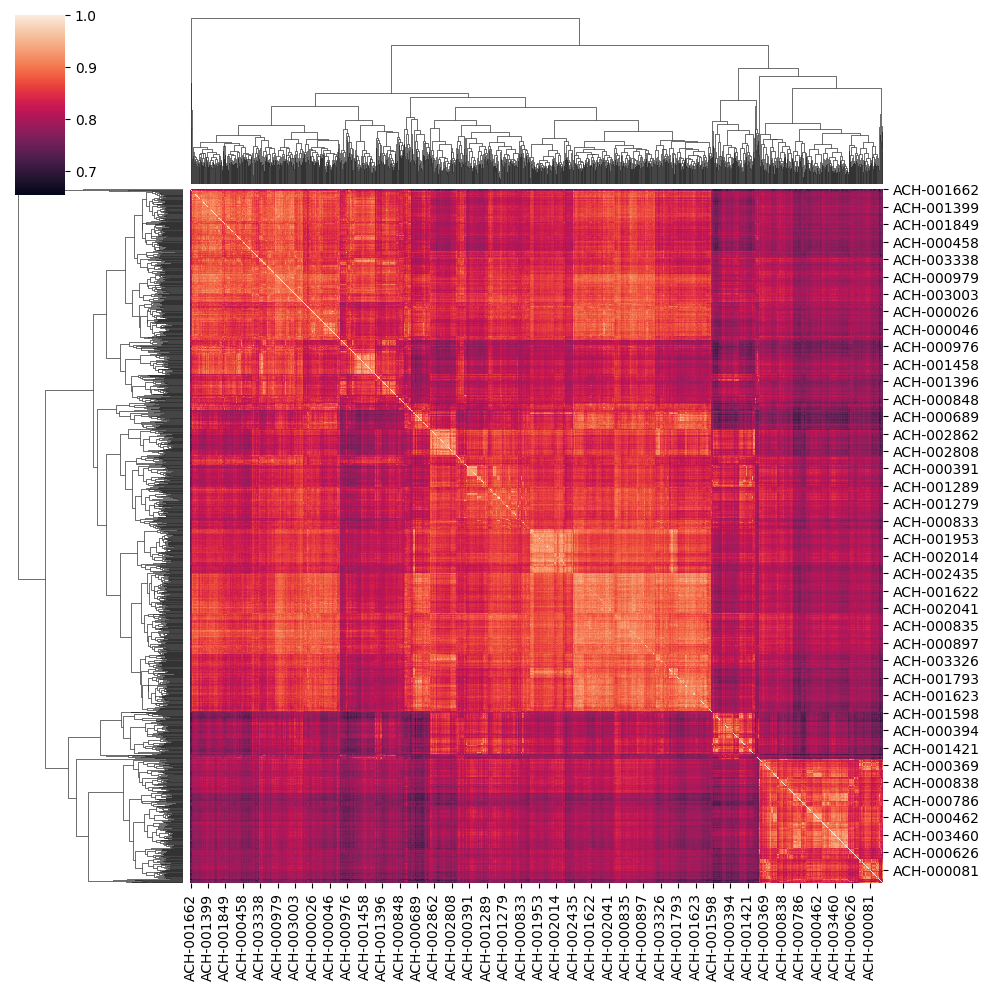

In [86]:
sns.clustermap(correlation_matrix)

In [87]:
#find correlation between the subtypes in the same lineage 

def get_pair(correlationdata, filtereddata, subtypes):
    """
    Generates pairs of subtypes and calculates their correlation comparisons.
    
    Parameters:
    - correlationdata (pd.DataFrame): The correlation matrix for samples.
    - filtereddata (pd.DataFrame): The DataFrame with filtered sample data and subtype information.
    - subtypes (list): List of subtypes to be compared.
    
    Returns:
    - list: A list of tuples where each tuple contains a pair of subtypes, their correlation comparisons,
      and the number of samples for each subtype.
    
    """
    subtype_pairs = []
    # between pairs
    for i, subtype1 in enumerate(subtypes):
        for subtype2 in subtypes[i+1:]:
            samples1 = filtereddata[filtereddata['subtype'] == subtype1]['sample']
            samples2 = filtereddata[filtereddata['subtype'] == subtype2]['sample']
            comparison = correlationdata.loc[samples1, samples2]
            subtype_pairs.append((subtype1, subtype2, comparison))
    
    # within-subtype
    for subtype in subtypes:
        samples = filtereddata[filtereddata['subtype'] == subtype]['sample']
        comparison = correlationdata.loc[samples, samples]
        subtype_pairs.append((subtype, subtype, comparison))

    return subtype_pairs
def get_pair_stat(subtype_pairs, correlation_data, filtered_data):
    """
    Computes the median correlation for each pair of subtypes.

    Parameters:
    - subtype_pairs (list): List of tuples containing subtype pairs and their correlation matrices.
    - correlation_data (pd.DataFrame): DataFrame with correlation values between samples.
    - filtered_data (pd.DataFrame): DataFrame with filtered sample data.

    Returns:
    - pd.DataFrame: DataFrame with subtype pairs and their median correlation values.
    """
    results = []
    
    for subtype1, subtype2, comparison in subtype_pairs:
        if not comparison.empty:
            if subtype1 == subtype2:
                # Compute median correlation for the lower triangle of the matrix if subtypes are the same
                tril = np.tril_indices(len(comparison), -1)
                median_corr = np.median(comparison.to_numpy()[tril])
            else:
                # Compute median correlation for the entire matrix if subtypes are different
                median_corr = np.median(comparison.to_numpy().flatten())
        
            # Append the result as a tuple (subtype1, subtype2, median_correlation) to the results list
            results.append((subtype1, subtype2, median_corr))
        else:
            # If the comparison matrix is empty, append NaNs for median correlation
            results.append((subtype1, subtype2, float('nan'), float('nan')))

    # Convert the results list to a DataFrame with specified column names
    return pd.DataFrame(results, columns=['col1', 'col2', 'median_correlation'])


In [88]:
def get_lineage_df(lineage, Dataforcorrelation, correlation_matrix):
    """
    Processes and analyzes data for a specific lineage to compute correlation between the subtypes of this lineage.

    Parameters:
    - lineage (str): The lineage to filter the data by.
    - Dataforcorrelation(pd.DataFrame): The datacontaining information about samples, including lineage
    - correlation_matrix: .

    Returns:
    - pd.DataFrame: A DataFrame containing statistics for each subtype pair within the specified lineage.
    """

    filtered_data = Dataforcorrelation[Dataforcorrelation.tissue == lineage]

    # Generate subtype pairs and calculate correlation statistics
    pairs = get_pair(correlation_matrix, filtered_data, filtered_data.subtype.unique().tolist())
    print(f"Pairs for lineage {lineage}: {len(pairs)}")
    
    # Compute statistical measures for the pairs
    tumor = get_pair_stat(pairs, correlation_matrix, filtered_data)
    print(f"Tumor stats for lineage {lineage}")
    
    return pd.DataFrame(tumor)


In [ ]:
lineage_dfs = []
# Iterate over each unique tissue type(lineage) in the Dataforcorrelation DataFrame
for lineage in Dataforcorrelation.tissue.unique():
    lineage_df = get_lineage_df(lineage, Dataforcorrelation, correlation_matrix)
    # Append the resulting DataFrame to the lineage_dfs list
    lineage_dfs.append(lineage_df)

# Concatenate all the lineage DataFrames into a single DataFrame
df = pd.concat(lineage_dfs)

In [ ]:
# contains subtype pairs in the same lineage and their median_correlation
table = pd.merge(df, Dataforcorrelation.drop(columns='sample'), left_on='col1', right_on='subtype', how='left')
table.drop_duplicates() 

In [92]:
# gets closets subtypes in tcga for subtypes in depmap 
def fill_parent_columns(table, tcga_meta, oncotree):
    def get_parent(subtype):
        if subtype.lower() in tcga_meta['derived_subtype'].str.lower().unique():
            return subtype
        else:
        # Check if subtype exists in oncotree
            if oncotree.loc[oncotree['name'] == subtype].empty:
                return None
        
            subtype_level = oncotree.loc[oncotree['name'] == subtype, 'level'].values[0]
            subtype_parent = oncotree.loc[oncotree['name'] == subtype, 'parent'].values[0]
        
        # Check for parents at the same level
            same_level_parents = oncotree.loc[(oncotree['level'] == subtype_level) & (oncotree['parent'] == subtype_parent)]['name'].unique()
            for same_level_parent in same_level_parents:
                if same_level_parent.lower() in tcga_meta['derived_subtype'].str.lower().unique():
                    return same_level_parent
        
        # If no valid parent subtype at the same level, check lower levels
            while subtype_level > 0:
                if oncotree.loc[oncotree['name'] == subtype_parent].empty:
                    return None
            
                grandparent = oncotree.loc[oncotree['name'] == subtype_parent, 'parent'].values[0]
                parent_siblings = oncotree.loc[(oncotree['parent'] == grandparent) & (oncotree['level'] == subtype_level)]['name'].unique()
                for parent_sibling in parent_siblings:
                    if parent_sibling.lower() in tcga_meta['derived_subtype'].str.lower().unique():
                        return parent_sibling
                subtype_level -= 1
                subtype_parent = grandparent  # Update the parent to grandparent for the next iteration
        
        return None
        # Make the parent columns for col1 and col2
    table['parent_col1'] = table['col1'].apply(get_parent)
    table['parent_col2'] = table['col2'].apply(get_parent)

    return table


In [93]:
#includes columns that have the nearest subtype in tcga 
updated_table = fill_parent_columns(table, tcga_meta, oncotree)
updated_table.drop_duplicates().to_csv('/Users/nabdirah/Project1/4fulldepmap.csv')

In [97]:
#subtypes in both tcga and depmap 
both_intcga=updated_table[(updated_table.col1==updated_table.parent_col1) | (updated_table.col2==updated_table.parent_col2)][['col1','col2']]
both_intcga
unique_subtypes = pd.concat([both_intcga['col1'], both_intcga['col2']]).unique()
len(unique_subtypes)

157

In [104]:
#unique_subtypes: subtypes in tcga
Data_subtype=[]
for subtype in unique_subtypes:
    sample=metadata[metadata.OncotreeCode.isin(oncotree.loc[oncotree['name']==subtype].index)]['ModelID']
    tissue=oncotree.loc[oncotree['name']==subtype]['tissue']
    Data_subtype.append((subtype,sample,tissue))


subtype_dfs = []
for subtype_name, sample_ids, tissue_series in Data_subtype:
    # Extract tissue information from Data_subtype which a pandas series 
    tissue = tissue_series.values[0]
    # Create a DataFrame for the current subtype
    df = pd.DataFrame({
        'sample': sample_ids,
        'subtype': subtype_name,
        'tissue': tissue
    })
    subtype_dfs.append(df)

Subtype_Df = pd.concat(subtype_dfs, ignore_index=True)
Subtype_Df.to_csv('/Users/nabdirah/Project1/5unique_Subtype_Df.csv')

In [101]:
#find correlation for the subtypes pairs that are one of them is also in tcga 
def get_pair(correlationdata, filtereddata, subtypes):
    """
    Generates pairs of subtypes and calculates their correlation comparisons.
    
    Parameters:
    - correlationdata (pd.DataFrame): The correlation matrix for samples.
    - filtereddata (pd.DataFrame): The DataFrame with filtered sample data and subtype information.
    - subtypes (list): List of subtypes to be compared.
    
    Returns:
    - list: A list of tuples where each tuple contains a pair of subtypes, their correlation comparisons,
      and the number of samples for each subtype.
    
    """
    subtype_pairs = []
    # between pairs
    for i, subtype1 in enumerate(subtypes):
        for subtype2 in subtypes[i+1:]:
            samples1 = filtereddata[filtereddata['subtype'] == subtype1]['sample']
            samples2 = filtereddata[filtereddata['subtype'] == subtype2]['sample']
            comparison = correlationdata.loc[samples1, samples2]
            subtype_pairs.append((subtype1, subtype2, comparison))
    
    # within-subtype
    for subtype in subtypes:
        samples = filtereddata[filtereddata['subtype'] == subtype]['sample']
        comparison = correlationdata.loc[samples, samples]
        subtype_pairs.append((subtype, subtype, comparison))

    return subtype_pairs
    
def get_pair_stat(subtype_pairs, correlation_data, filtered_data):
    """
    Computes the median correlation for each pair of subtypes.

    Parameters:
    - subtype_pairs (list): List of tuples containing subtype pairs and their correlation matrices.
    - correlation_data (pd.DataFrame): DataFrame with correlation values between samples.
    - filtered_data (pd.DataFrame): DataFrame with filtered sample data.

    Returns:
    - pd.DataFrame: DataFrame with subtype pairs and their median correlation values.
    """
    results = []
    
    for subtype1, subtype2, comparison in subtype_pairs:
        if not comparison.empty:
            if subtype1 == subtype2:
                # Compute median correlation for the lower triangle of the matrix if subtypes are the same
                tril = np.tril_indices(len(comparison), -1)
                median_corr = np.median(comparison.to_numpy()[tril])
            else:
                # Compute median correlation for the entire matrix if subtypes are different
                median_corr = np.median(comparison.to_numpy().flatten())
        
            # Append the result as a tuple (subtype1, subtype2, median_correlation) to the results list
            results.append((subtype1, subtype2, median_corr))
        else:
            # If the comparison matrix is empty, append NaNs for median correlation
            results.append((subtype1, subtype2, float('nan'), float('nan')))

    # Convert the results list to a DataFrame with specified column names
    return pd.DataFrame(results, columns=['col1', 'col2', 'median_correlation'])



In [ ]:
def get_sub_df(lineage, Subtype_Df, expr_depmap):
    """
    Processes and analyzes data for a specific lineage to compute correlation statistics.

    Parameters:
    - lineage (str): The lineage to filter the data by.
    - tcga_meta (pd.DataFrame): The metadata DataFrame containing information about samples, including 'derived_lineage' and 'sampleID'.
    - expr (pd.DataFrame): The expression data with samples as rows and features as columns.

    Returns:
    - pd.DataFrame: A DataFrame containing statistics for each subtype pair within the specified lineage.
    """

    print("Initial filtered data")

    # Filter data for the specified lineage
    print(f"Filtered data for lineage {lineage}")
    filtered_data = Subtype_Df[Subtype_Df['tissue'] == lineage]
    valid_ids = expr_depmap.index.intersection(pd.Index(filtered_data['sample']))
    print(f"Valid IDs: {len(valid_ids)}")
    filtered_data = filtered_data.loc[filtered_data['sample'].isin(valid_ids)]
    correlation_data = expr_depmap.loc[expr_depmap.index.isin(filtered_data['sample'])].dropna().T.corr()
    
    # Generate subtype pairs and calculate correlation statistics
    pairs = get_pair(correlation_data, filtered_data, filtered_data.subtype.unique().tolist())
    print(f"Pairs for lineage {lineage}: {len(pairs)}")
    
    # Compute statistical measures for the pairs
    tumor = get_pair_stat(pairs, correlation_data, filtered_data)
    print(f"Tumor stats for lineage {lineage}")
    
    return pd.DataFrame(tumor)
    
subtypes_corr=[]
for lineage in Subtype_Df['tissue'].unique():
    subtype_corr=get_sub_df(lineage,Subtype_Df,expr_depmap)
    subtypes_corr.append(subtype_corr)
unique_subtype_df = pd.concat(subtypes_corr) 

In [ ]:
#check which lineages have one subtype 
onelineage=[]
for lineage in Dataforcorrelation.tissue.unique():
    if len(Dataforcorrelation[Dataforcorrelation.tissue==lineage]['subtype'].unique())==1:
        onesublineage=lineage
        onelineage.append(onesublineage)
onelineage
# the lineages with one subtype 
table[table.subtype.isin(['Pancreas', 'Ampulla of Vater', 'Adrenal Gland', 'Head and Neck', 'Other'])]

In [111]:
#save tables 
unique_subtype_df.to_csv('/Users/nabdirah/Project1/5Depunique_subtypecorrelation.csv')
table.to_csv('/Users/nabdirah/Project1/depmap_corr.csv')
